In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium

In [14]:
import pandas as pd
url = "https://data.sfgov.org/resource/vw6y-z8j6.csv?$limit=50000"
df = pd.read_csv(url)
print(f"Loaded {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()



Loaded 50000 rows and 52 columns.


,service_request_id,requested_datetime,closed_date,updated_datetime,status_description,status_notes,agency_responsible,service_name,service_subtype,service_details,...,:@computed_region_pigm_ib2e,:@computed_region_9jxd_iqea,:@computed_region_6ezc_tdp2,:@computed_region_6pnf_4xz7,:@computed_region_h4ep_8xdi,:@computed_region_nqbw_i6c3,:@computed_region_2dwj_jsy4,:@computed_region_y6ts_4iup,:@computed_region_jwn9_ihcz,:@computed_region_6qbp_sg9q
0,13437452,2021-02-01T07:48:00.000,2021-02-02T09:25:00.000,2021-02-02T09:25:00.000,Closed,Case Resolved,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,...,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,53.0,53.0
1,9657146,2018-10-11T09:51:00.000,2018-10-11T10:59:00.000,2018-10-11T10:59:00.000,Closed,Case Resolved,DPW Ops Queue,Street and Sidewalk Cleaning,Human or Animal Waste,Human or Animal Waste,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,106.0,106.0
2,13461310,2021-02-06T15:55:00.000,2021-02-06T19:38:53.000,2021-02-06T19:38:53.000,Closed,Case Resolved - Completed,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,8.0,8.0
3,13465537,2021-02-08T08:06:00.000,2021-02-09T10:37:00.000,2021-02-09T10:37:00.000,Closed,Case Resolved,DPW Ops Queue,Street and Sidewalk Cleaning,Human or Animal Waste,Human or Animal Waste,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,78.0,78.0
4,13475791,2021-02-10T11:26:00.000,2021-02-12T09:10:24.000,2021-02-12T09:10:24.000,Closed,Case Resolved - WASTE NOT FOUND,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Boxed or Bagged Items,...,14.0,NaN,NaN,2.0,NaN,3.0,NaN,NaN,53.0,53.0


In [15]:
drop_cols = [col for col in df.columns if col.startswith(':@computed_region') or col in [
    'point_geom', 'point', 'media_url', 'source', 'bos_2012', 'data_as_of',
    'data_loaded_at', 'street', 'supervisor_district', 'closed_date', 'updated_datetime',
    'service_name', 'agency_responsible', 'service_request_id', 'status_notes',
    'police_district'
]]
df = df.drop(columns=drop_cols)


In [16]:
df.columns

Index(['requested_datetime', 'status_description', 'service_subtype',
       'service_details', 'address', 'neighborhoods_sffind_boundaries',
       'analysis_neighborhood', 'lat', 'long'],
      dtype='object')

In [17]:
df.rename(columns={'lat': 'latitude', 'long': 'longitude'}, inplace=True)
df = df.dropna(subset=['latitude', 'longitude'])

In [18]:
df['requested_datetime'] = pd.to_datetime(df['requested_datetime'], errors='coerce')
df = df.dropna(subset=['requested_datetime'])  # Remove rows with invalid dates
df['month'] = df['requested_datetime'].dt.to_period('M')

In [19]:
relevant_types = [
    'Illegal Postings', 'Graffiti', 'Street or Sidewalk Cleaning',
    'Encampments', 'Litter Receptacles'
]
df = df[df['service_subtype'].isin(relevant_types)]

# Final preview
print(f"Shape after cleaning: {df.shape}")
print(df[['requested_datetime', 'service_subtype', 'status_description', 
          'analysis_neighborhood', 'latitude', 'longitude']].head())

Shape after cleaning: (19, 10)
      requested_datetime service_subtype status_description  \
1103 2021-02-10 12:10:00        Graffiti             Closed   
1848 2022-04-10 12:51:00        Graffiti             Closed   
2342 2022-04-12 11:22:00        Graffiti             Closed   
4054 2021-02-01 16:35:00        Graffiti             Closed   
6600 2021-01-26 11:25:00        Graffiti             Closed   

     analysis_neighborhood   latitude   longitude  
1103          Hayes Valley  37.775513 -122.421860  
1848          McLaren Park  37.720234 -122.425476  
2342    West of Twin Peaks  37.737835 -122.450027  
4054                Marina  37.800053 -122.434402  
6600          Hayes Valley  37.773617 -122.426933  


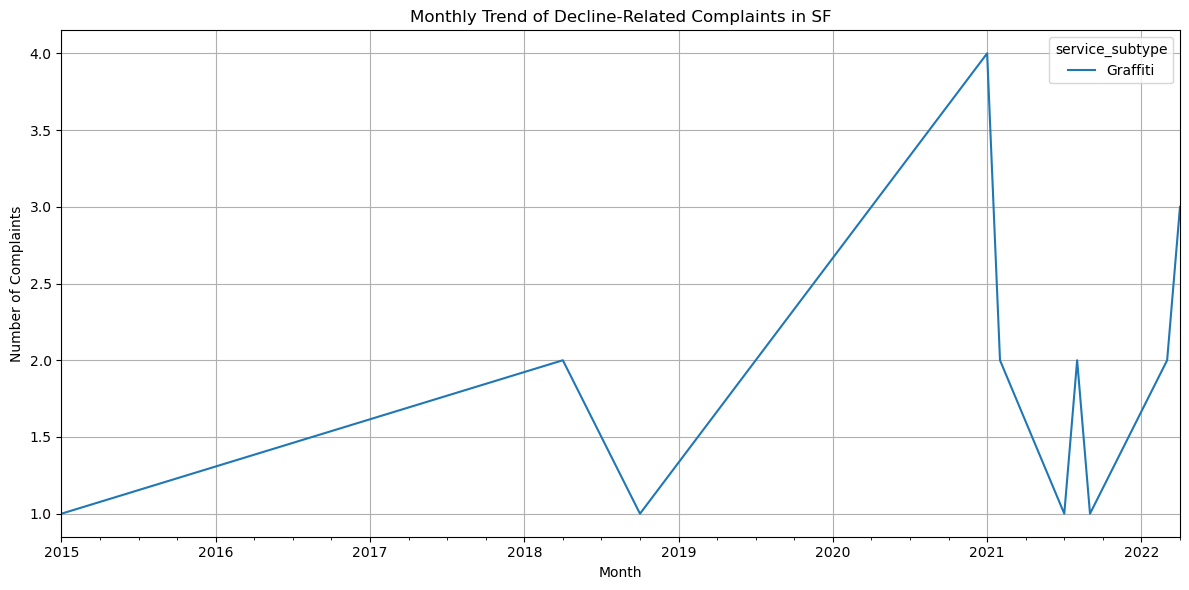

In [20]:
import matplotlib.pyplot as plt


trend = df.groupby(['month', 'service_subtype']).size().unstack().fillna(0)

trend.plot(figsize=(12, 6), title='Monthly Trend of Decline-Related Complaints in SF')
plt.xlabel('Month')
plt.ylabel('Number of Complaints')
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
import folium


sf_map = folium.Map(location=[37.7749, -122.4194], zoom_start=13)


for _, row in df.sample(min(1000, len(df))).iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.5,
        popup=row['service_subtype']
    ).add_to(sf_map)

sf_map
